# Mini Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler


import torchvision
from torchvision import datasets
from torchvision import transforms

import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Import CIFAR10 Dataset and Setup Data Loaders.

With reference to the pytorch tutorial, we used the standard normalization for both training and test data.

In [2]:
# set up training and testing data loader
# ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# use a batch size of 128 as a safe choice: https://myrtle.ai/learn/how-to-train-your-resnet-2-mini-batches/
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Section 1: Modification of ResNet 18

In this section, we referenced the code for the regular ResNet. Modifying the ResNet-18 structure, we use the same B(3, 3) residual block structure, which stacks two 3-by-3 convolution layers. Instead, we changed the intermediate channel size to 64, 128, 128, 256. This results in a total parameter size of 3.39M. 

In [9]:
# Reference: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
# B(3,3) box structure.
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# modifies Resnet-18
model = ResNet(BasicBlock, [2, 2, 2, 2])

In [10]:
# print number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters()) 
print("Total number of Parameters for model 1 is: ", sum([np.prod(p.size()) for p in model_parameters]))

Total number of Parameters for model 1 is:  3385162


### Model Training 

This code is slightly different from the code used for the result in the report. For the result in the report, the learning rate is adjusted manually. The below implementation is based on a fixed learning rate schedule.

In [ ]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0005)

# training the model
train_loss_history = [] 
train_acc_history = []
test_loss_history = []
test_acc_history = []
run_time = []

for epoch in range(50):  # loop over the dataset multiple times
    print(epoch)
    # set learning rate
    if epoch < 15:
        optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0005)
    else:
        optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0005)
        
    start_time = time.time()
    train_loss, test_loss, train_acc, test_acc = 0.0, 0.0, 0.0, 0.0
    # train the model
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()/labels.size(0)
    end_time = time.time()
    for i, data in enumerate(testloader):
        with torch.no_grad():
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_loss += loss.item()
            test_acc += (predicted == labels).sum().item()/labels.size(0)

    # save last model
    torch.save(model.state_dict(), 'model_resnet18.pt')
    # save current statistics
    train_loss_history.append(train_loss/len(trainloader))
    train_acc_history.append(train_acc/len(trainloader))
    test_loss_history.append(test_loss/len(testloader))
    test_acc_history.append(test_acc/len(testloader))
    run_time.append(end_time - start_time)

    df = pd.DataFrame({'train_loss': train_loss_history, 'train_acc': train_acc_history, 'test_loss': test_loss_history, 'test_acc': test_acc_history, 'run_time':run_time} ) 
    df.to_csv('model18_statistic.csv') 

Visualize the training progress.

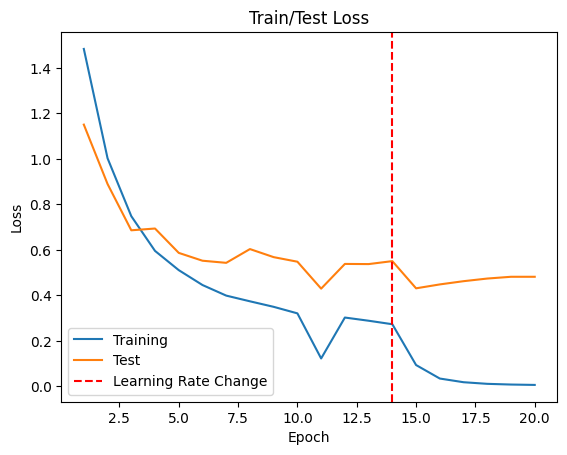

In [49]:
outcome = pd.read_csv('model18_statistic.csv')
epoch = np.arange(1, 21)
plt.plot(epoch, outcome['train_loss'].to_numpy(), label = "Training")
plt.plot(epoch, outcome['test_loss'].to_numpy(), label = "Test")
plt.axvline(x = 14, color = 'r', label = 'Learning Rate Change', linestyle = '--')
plt.title('Train/Test Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


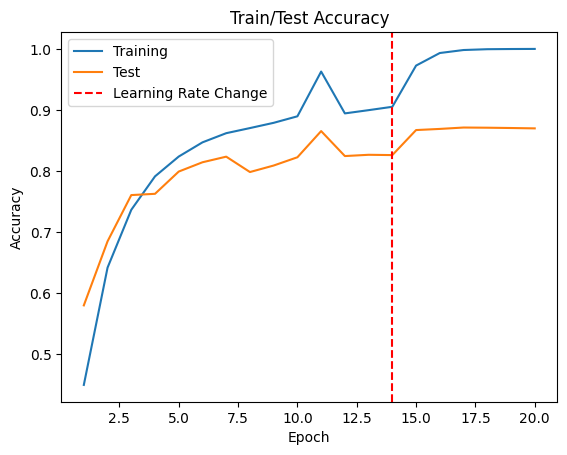

In [50]:
plt.plot(epoch, outcome['train_acc'].to_numpy(), label = "Training")
plt.plot(epoch, outcome['test_acc'].to_numpy(), label = "Test")
plt.axvline(x = 14, color = 'r', label = 'Learning Rate Change', linestyle = '--')
plt.title('Train/Test Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Wide-ResNet (2x)

In [35]:
# use wide-ResNet to reduce parameter counts
# paper ref: https://arxiv.org/pdf/1605.07146v4.pdf
# code ref: https://github.com/szagoruyko/wide-residual-networks
# code ref 2: https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/wide_resnet.py
# also tensorflow implementation code here: https://github.com/transcranial/wide-resnet/blob/master/wide-resnet.ipynb

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

model = Wide_ResNet(28, 2, 0.3, 10)

| Wide-Resnet 28x2


In [36]:
# print number if parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters()) 
print("Total number of Parameters is: ", sum([np.prod(p.size()) for p in model_parameters]))

Total number of Parameters is:  1469642


In [ ]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0005)

# training the model
train_loss_history = [] 
train_acc_history = []
test_loss_history = []
test_acc_history = []
run_time = []

for epoch in range(50):  # loop over the dataset multiple times
    print(epoch)
    # set learning rate
    if epoch < 15:
        optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0005)
    else:
        optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0005)
        
    start_time = time.time()
    train_loss, test_loss, train_acc, test_acc = 0.0, 0.0, 0.0, 0.0
    # train the model
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()/labels.size(0)
    end_time = time.time()
    for i, data in enumerate(testloader):
        with torch.no_grad():
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_loss += loss.item()
            test_acc += (predicted == labels).sum().item()/labels.size(0)

    # save last model
    torch.save(model.state_dict(), 'model2.pt')
    # save current statistics
    train_loss_history.append(train_loss/len(trainloader))
    train_acc_history.append(train_acc/len(trainloader))
    test_loss_history.append(test_loss/len(testloader))
    test_acc_history.append(test_acc/len(testloader))
    run_time.append(end_time - start_time)

    df = pd.DataFrame({'train_loss': train_loss_history, 'train_acc': train_acc_history, 'test_loss': test_loss_history, 'test_acc': test_acc_history, 'run_time':run_time} ) 
    df.to_csv('model_statistic2w.csv')  

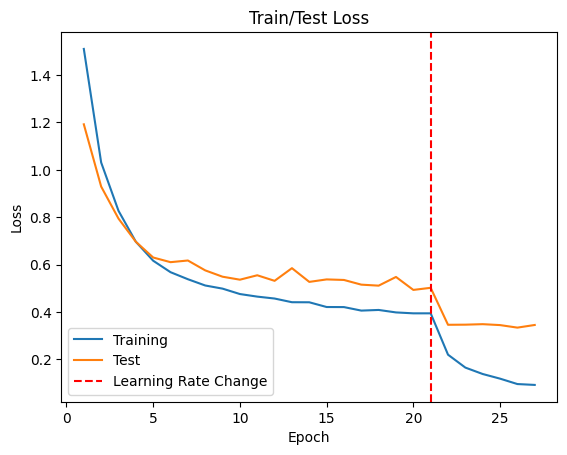

In [51]:
outcome = pd.read_csv('model_statistic2w.csv')
epoch = np.arange(1, 28)
plt.plot(epoch, outcome['train_loss'].to_numpy(), label = "Training")
plt.plot(epoch, outcome['test_loss'].to_numpy(), label = "Test")
plt.axvline(x = 21, color = 'r', label = 'Learning Rate Change', linestyle = '--')
plt.title('Train/Test Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

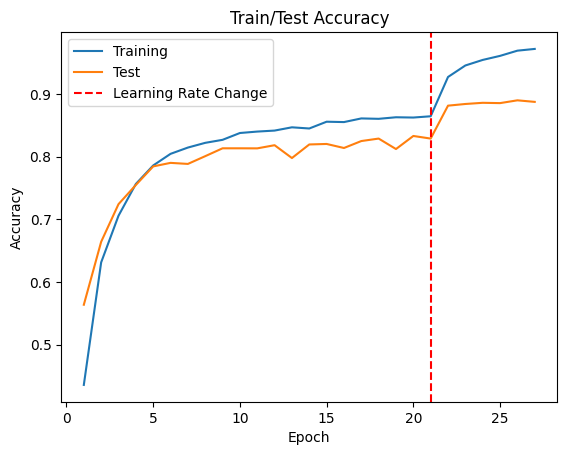

In [52]:
plt.plot(epoch, outcome['train_acc'].to_numpy(), label = "Training")
plt.plot(epoch, outcome['test_acc'].to_numpy(), label = "Test")
plt.axvline(x = 21, color = 'r', label = 'Learning Rate Change', linestyle = '--')
plt.title('Train/Test Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Wide-ResNet (3x)

In [53]:
# print number if parameters
model = Wide_ResNet(28, 3, 0.3, 10)
model_parameters = filter(lambda p: p.requires_grad, model.parameters()) 
print("Total number of Parameters is: ", sum([np.prod(p.size()) for p in model_parameters]))

| Wide-Resnet 28x3
Total number of Parameters is:  3297082


In [5]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0005)

In [6]:
outcome = pd.read_csv('model_statistic3w.csv')
train_loss_history = list(outcome['train_loss'])
train_acc_history = list(outcome['train_acc'])
test_loss_history = list(outcome['test_loss'])
test_acc_history = list(outcome['test_acc'])
run_time = list(outcome['run_time'])
model.load_state_dict(torch.load('model3.pt'))

<All keys matched successfully>

In [54]:
#training the model
train_loss_history = [] 
train_acc_history = []
test_loss_history = []
test_acc_history = []
run_time = []

for epoch in range(14):  # loop over the dataset multiple times
    print(epoch)
    start_time = time.time()
    train_loss, test_loss, train_acc, test_acc = 0.0, 0.0, 0.0, 0.0
    # train the model
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()/labels.size(0)
    end_time = time.time()
    for i, data in enumerate(testloader):
        with torch.no_grad():
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_loss += loss.item()
            test_acc += (predicted == labels).sum().item()/labels.size(0)

    # save last model
    torch.save(model.state_dict(), 'model3.pt')
    # save current statistics
    train_loss_history.append(train_loss/len(trainloader))
    train_acc_history.append(train_acc/len(trainloader))
    test_loss_history.append(test_loss/len(testloader))
    test_acc_history.append(test_acc/len(testloader))
    run_time.append(end_time - start_time)
    df = pd.DataFrame({'train_loss': train_loss_history, 'train_acc': train_acc_history, 'test_loss': test_loss_history, 'test_acc': test_acc_history, 'run_time':run_time} ) 
    df.to_csv('model_statistic3w.csv') 

0


KeyboardInterrupt: 

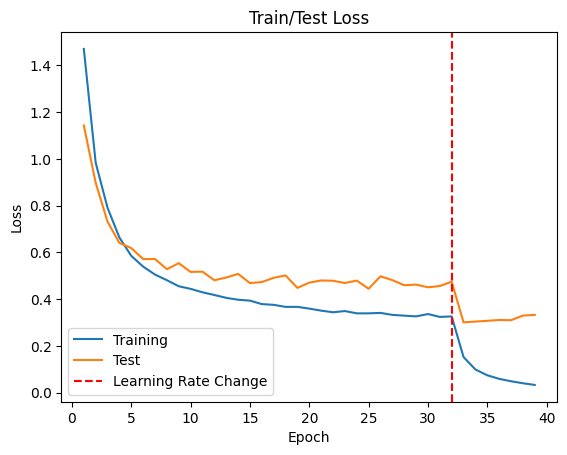

In [59]:
outcome = pd.read_csv('model_statistic3w.csv')
epoch = np.arange(1, 40)
plt.plot(epoch, outcome['train_loss'].to_numpy(), label = "Training")
plt.plot(epoch, outcome['test_loss'].to_numpy(), label = "Test")
plt.axvline(x = 32, color = 'r', label = 'Learning Rate Change', linestyle = '--')
plt.title('Train/Test Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

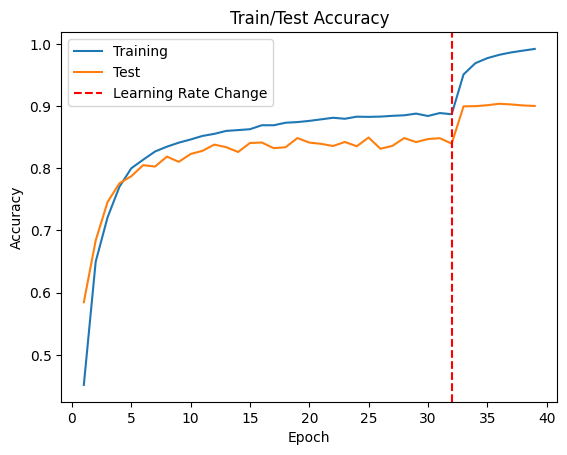

In [60]:
plt.plot(epoch, outcome['train_acc'].to_numpy(), label = "Training")
plt.plot(epoch, outcome['test_acc'].to_numpy(), label = "Test")
plt.axvline(x = 32, color = 'r', label = 'Learning Rate Change', linestyle = '--')
plt.title('Train/Test Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()